In [1]:
import os
import csv
import pandas as pd
import time
import pickle
import sys
import datetime
import numpy as np


In [2]:
print(os.getcwd())
# it should end with this: /AITutor_SeqModeling
# if not, run the next block


/local-scratch/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/SeqModel


In [3]:
# run if the current directory is not AITutor_SeqModeling
cwd = os.chdir(os.path.join(os.getcwd(), ".."))
print(os.getcwd())

/local-scratch/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling


In [4]:
File_xlsx = "data/integration_log_group_a.xlsx"

df = pd.read_excel(File_xlsx)
df = df.iloc[:, :-1] 

print(df.head())

  username           Date and Time Time since session started\n(h:mm:ss)  \
0       a1 2023-08-03 09:34:57.240                              00:00:00   
1       a1 2023-08-03 09:35:00.152                              00:00:02   
2       a1 2023-08-03 09:35:30.167                              00:00:32   
3       a1 2023-08-03 09:41:32.112                              00:06:34   
4       a1 2023-08-03 09:41:32.112                              00:06:34   

         space                     action  
0          NaN                 User login  
1   /courses/1                  Load page  
2  EDA Toolbox  Load default toolbox page  
3    Problem 1              Start problem  
4    Problem 1               First answer  


In [5]:
# augment group_b at the end of it
File_xlsx = "data/integration_log_group_b.xlsx"


df_b = pd.read_excel(File_xlsx)
df_b = df_b.iloc[:, :-1]

df = pd.concat([df, df_b], axis=0)
print(df)

      username           Date and Time Time since session started\n(h:mm:ss)  \
0           a1 2023-08-03 09:34:57.240                              00:00:00   
1           a1 2023-08-03 09:35:00.152                              00:00:02   
2           a1 2023-08-03 09:35:30.167                              00:00:32   
3           a1 2023-08-03 09:41:32.112                              00:06:34   
4           a1 2023-08-03 09:41:32.112                              00:06:34   
...        ...                     ...                                   ...   
22209      b51 2023-09-21 12:05:15.996                              02:37:57   
22210      b51 2023-09-21 12:05:39.705                              02:38:21   
22211      b51 2023-09-21 21:00:11.019                              11:32:52   
22212      b51 2023-09-21 21:00:11.043                              11:32:52   
22213      b51 2023-09-22 07:32:32.204                              22:05:14   

             space                     

In [6]:
# read the scores
File_score_xlsx = ["data/Groupa_scores.xlsx", "data/Groupb_scores.xlsx"]

for i in range(2):
    # read the scores
    read_file = pd.read_excel(File_score_xlsx[i])

    # change the first column name to username
    read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                            'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
    
    # use the username as the index
    read_file.set_index('username', inplace=True)
    # devide first column by 16, second column by 20, third column by 18
    read_file['score1'] = read_file['score1'].div(16)
    read_file['score2'] = read_file['score2'].div(20)
    read_file['score3'] = read_file['score3'].div(18)
    if i:
        read_file = read_file[:-4]
        score_df = pd.concat([score_df, read_file], axis=0)
    else:
        read_file = read_file[:-3]
        score_df = read_file.copy()

print(score_df)

          score1  score2    score3
username                          
a1        0.6875    0.45  0.583333
a2        0.4375    0.00  0.000000
a3        0.6250    0.35  0.166667
a4        0.5000    0.45  0.000000
a5        0.4375    0.30  0.194444
...          ...     ...       ...
b46       0.8750    0.45  0.194444
b47       0.5000    0.30  0.555556
b48       0.3125    0.40  0.138889
b49       0.4375    0.40  0.472222
b51       0.3750    0.40  0.444444

[89 rows x 3 columns]


In [7]:
# convert the score_df to a df series the value is the score.
# it should look like this:
# username probelm score
# a1        1       0.5
# a1        2       0.6
# a1        3       0.7
# a2        1       0.6


score_df = score_df.stack().reset_index()
score_df.columns = ['username', 'problem', 'score']
# replace score1, score2, score3 with 1, 2, 3
score_df['problem'] = score_df['problem'].str.replace('score', '').astype(int)
print(score_df)

    username  problem     score
0         a1        1  0.687500
1         a1        2  0.450000
2         a1        3  0.583333
3         a2        1  0.437500
4         a2        2  0.000000
..       ...      ...       ...
262      b49        2  0.400000
263      b49        3  0.472222
264      b51        1  0.375000
265      b51        2  0.400000
266      b51        3  0.444444

[267 rows x 3 columns]


In [8]:
# have a copy of the original df (run to reset)
if 'df_org' not in globals():
    df_org = df.copy()
else:
    df = df_org.copy()

In [9]:
# get the unique values of the column action
unique_actions = df.action.unique()
# peint unique actions with their counts
print(df['action'].value_counts())

action
Change answer                      11370
First answer                        4569
Update confidence                   2996
Request another hint                2712
Streamlit interaction               2451
New answer explanation              2108
Auto-save log                       1874
Request first hint                  1788
Paste answer                        1662
Update answer explanation           1622
Load default toolbox page           1576
Load page                           1306
Freeform code run                   1258
Run code error                       624
Run code                             577
Start reading sub-module             448
User request                         400
Chatbot response                     400
Respond to hint feedback             385
Start problem                        254
Submit problem                       235
Complete sub-module                  122
User login                           111
Save note                             56
Stop read

In [10]:
# remove entries in df that are 'Save note','Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'
df = df[~df['action'].isin(['Save note','Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem', 'Stop reading sub-module preview', 'Chatbot response'])]
# get the unique values of the column action
unique_actions = df.action.unique()
# peint unique actions with their counts
print(df['action'].value_counts())

action
Change answer                11370
First answer                  4569
Update confidence             2996
Request another hint          2712
Streamlit interaction         2451
New answer explanation        2108
Request first hint            1788
Paste answer                  1662
Update answer explanation     1622
Freeform code run             1258
Run code                       577
User request                   400
Respond to hint feedback       385
Complete sub-module            122
Name: count, dtype: int64


In [11]:
df['space'].value_counts()

space
Problem 3      10570
Problem 2      10530
Problem 1       9370
EDA Toolbox     2451
Code Editor      577
AI Chatbot       400
Library          122
Name: count, dtype: int64

In [12]:
df['space'] = df['space'].replace('Problem 3', 3)
df['space'] = df['space'].replace('Problem 2', 2)
df['space'] = df['space'].replace('Problem 1', 1)
# if the space is not int, make it np.nan
df['space'] = pd.to_numeric(df['space'], errors='coerce')
# # if the space is not 1,2,3 change it to the value of the previous row
df['space'] = df['space'].fillna(method='ffill')
# change dtyle of space to Int64
df['space'] = df['space'].astype('Int64')
df['space'].value_counts()


space
1    11807
2    11416
3    10797
Name: count, dtype: Int64

In [13]:
# check for type(df.iloc[i, 2]) if is not datetime.time, then convert it to datetime.time
df = df.drop(columns=['Date and Time']) 
for i in range(len(df)):
    if type(df.iloc[i, 1]) != datetime.time:
        df.iloc[i, 1] = df.iloc[i, 1].time()
# rename second column to time
df.rename(columns={df.columns[1]: 'time'}, inplace=True)
df.rename(columns={df.columns[2]: 'problem'}, inplace=True)


In [14]:
# create a map for actions
# create a map for actions
action_map = {
    'Change answer': 'UA',
    'First answer': 'FA',
    'Paste answer': 'PA',
    'Request first hint': 'FH',
    'Request another hint': 'UH',
    'Respond to hint feedback': 'RH',
    'New answer explanation': 'FE',
    'Update answer explanation': 'UE',
    'Freeform code run': 'RF',
    'Run code': 'RC',
    'User request': 'B',
    'Update confidence': 'C',
    'Complete sub-module': 'M',
    'Streamlit interaction': 'S'
}

# map the actions
df['action'] = df['action'].map(action_map)
df


,username,time,problem,action
4,a1,00:06:34,1,FA
5,a1,00:06:36,1,FE
6,a1,00:06:49,1,UE
7,a1,00:07:13,1,UE
8,a1,00:07:38,1,UE
...,...,...,...,...
22205,b51,02:37:36,3,UH
22206,b51,02:37:36,3,UH
22207,b51,02:37:45,3,PA
22208,b51,02:37:47,3,UA


In [15]:
# in column time, compute the difference between the current row and the previous row in seconds, only if the username and probem are the same
# otherwise, put np.nan
df['duration']=np.nan
for i in range(1, len(df)):
    if df.iloc[i, 0] == df.iloc[i-1, 0] and df.iloc[i, 2] == df.iloc[i-1, 2]:
        df.iloc[i, 4] = (datetime.datetime.combine(datetime.datetime.today(), df.iloc[i, 1])
            - datetime.datetime.combine(datetime.datetime.today(), df.iloc[i-1, 1])).total_seconds()
# remove the time column
df = df.drop(columns=['time'])
df

,username,problem,action,duration
4,a1,1,FA,NaN
5,a1,1,FE,2.0
6,a1,1,UE,13.0
7,a1,1,UE,24.0
8,a1,1,UE,25.0
...,...,...,...,...
22205,b51,3,UH,0.0
22206,b51,3,UH,0.0
22207,b51,3,PA,9.0
22208,b51,3,UA,2.0


In [16]:
# if there is a negative value in the duration column, replace it with np.nan
df['duration'] = df['duration'].apply(lambda x: np.nan if x < 0 else x)
# if it is greater than 1200, replace it with np.nan
df['duration'] = df['duration'].apply(lambda x: np.nan if x > 1200 else x)


In [17]:
# impute the missing values in duration with the mean of the duration in the same problem and username
df['duration'] = df['duration'].fillna(df.groupby(['username', 'problem'])['duration'].transform('mean'))
df

,username,problem,action,duration
4,a1,1,FA,24.81457
5,a1,1,FE,2.00000
6,a1,1,UE,13.00000
7,a1,1,UE,24.00000
8,a1,1,UE,25.00000
...,...,...,...,...
22205,b51,3,UH,0.00000
22206,b51,3,UH,0.00000
22207,b51,3,PA,9.00000
22208,b51,3,UA,2.00000


In [18]:
# describe the df 
df.describe()

,problem,duration
count,34020.0,34020.000000
mean,1.970312,19.510460
std,0.814599,47.330066
min,1.0,0.000000
25%,1.0,2.000000
50%,2.0,5.000000
75%,3.0,19.000000
max,3.0,1198.000000


In [19]:
# decode the duration colomn as follows:
# 0-1: '0'
# 1-5: '1'
# 5-10: '2'
# 10-15: '3'
# 15-20: '4'
# 20-30: ''5'
# 30-60: '6'
# 60-120: '7'
# 120-300: '8'
# 300-MAX: 'MAX'

df['duration'] = pd.cut(df['duration'], bins=[-0.1, 1, 5, 10, 15, 20, 30, 60, 120, 300, df['duration'].max()], labels=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'TMAX'])
df


,username,problem,action,duration
4,a1,1,FA,T5
5,a1,1,FE,T1
6,a1,1,UE,T3
7,a1,1,UE,T5
8,a1,1,UE,T5
...,...,...,...,...
22205,b51,3,UH,T0
22206,b51,3,UH,T0
22207,b51,3,PA,T2
22208,b51,3,UA,T1


In [20]:
# for each username and problem, create a numpy array of the pair of actions, duration in the order they appear
# Then put the numpy array in a dictionary with the key as the username and problem
# example:
# (a1, 1): [UA, T0, FA, T1, PA, T2]
# (a1, 2): [UA, T0, FA, T1, PA, T2, FH, T3]
# (a2, 1): [UA, T0, FA, T1, PA, T2, FH, T3, UH, T4]

# create a dictionary
df_dict = {}
for i in range(len(df)):
    if (df.iloc[i, 0], df.iloc[i, 1]) in df_dict:
        df_dict[(df.iloc[i, 0], df.iloc[i, 1])].extend([df.iloc[i, 2], df.iloc[i, 3]])
    else:
        df_dict[(df.iloc[i, 0], df.iloc[i, 1])] = ['Q{}'.format(df.iloc[i, 1]), df.iloc[i, 2], df.iloc[i, 3]]

# # convert the list to numpy array
# for key in df_dict.keys():
#     df_dict[key] = np.array(df_dict[key])
     

print("number of sequence episode we have", len(df_dict.keys()))
print("number of scores we have ", len(score_df))

number of sequence episode we have 254
number of scores we have  267


In [21]:
# for each key in the dictionary, find the score and append the values to a list (sequences) and the score to another list (scores)
# len(sequences) should be equal to len(scores)

sequences = []
scores = []
for key in df_dict.keys():
        sequences.append(df_dict[key])
        scores.append(score_df[(score_df['username'] == key[0]) & (score_df['problem'] == key[1])]['score'].values.tolist())

print(len(sequences), len(scores))

254 254


In [22]:
# if scores is empty, replace it with 0
scores = [[0] if len(x) == 0 else x for x in scores]

In [23]:
# train the model
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import wandb
import torch.nn as nn


/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
print(wandb.__path__)

['/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/wandb']


In [25]:
wandb.init(project="DaTu_prediction", entity="marslab", name = "bert-base-uncased")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedramagand (marslab). Use `wandb login --relogin` to force relogin


In [26]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)  # num_labels=1 for regression


/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
new_tokens = ['UA','FA','PA','FH', 'UH', 'RH','FE', 'UE','RF', 'RC', 'B', 'C','M', 'S',
    'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'TMAX', 
    'Q1', 'Q2', 'Q3']

tokenizer.add_tokens(new_tokens)

model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size to include new tokens


Embedding(30538, 768)

In [28]:
class DaTuDataset(Dataset):
    def __init__(self, sequences, scores, tokenizer, max_length=512):
        self.sequences = sequences
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        score = self.scores[idx]
        
        # Tokenize the sequence
        inputs = self.tokenizer.encode_plus(
            sequence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_length,  # Max length to truncate/pad
            padding='max_length',  # Pad to max_length
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  # Return PyTorch tensors
        )
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': torch.tensor(score, dtype=torch.float)
        }
        #inputs.input_ids.squeeze(0), inputs.attention_mask.squeeze(0), torch.tensor(score, dtype=torch.float)


In [29]:
# chceck if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30538, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [30]:
# Create the dataset and dataloader
dataset = DaTuDataset(sequences,  scores, tokenizer)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=None)


In [31]:
len(dataset)

254

In [32]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# Optimizer and Learning Rate Scheduler
epochs = 50
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4, num_training_steps=total_steps)


/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Training loop
def train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        i = 0
        for batch in train_dataloader:

            batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}  # Move batch to device
            outputs = model(**batch)

            # input_ids, attention_mask, labels = [b.to(device) for b in batch]
            # outputs = model(input_ids, attention_mask=attention_mask, labels=labels.float())
            
            loss = outputs.loss
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            
        avg_train_loss = total_loss / len(train_dataloader)
        wandb.log({"train_loss": avg_train_loss, 'epoch': epoch+1})

        # Validation loop
        model.eval()
        val_loss = 0
        for batch in val_dataloader:
            i+=1
            batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}  # Move batch to device
            with torch.no_grad():
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_dataloader)
        wandb.log({"validation_loss": avg_val_loss, 'epoch': epoch+1})


        if epoch % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.3f} | Validation Loss: {avg_val_loss:.3f}")


In [57]:
train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Epoch 1/50 | Train Loss: 0.061 | Validation Loss: 0.060
Epoch 2/50 | Train Loss: 0.067 | Validation Loss: 0.077
Epoch 3/50 | Train Loss: 0.074 | Validation Loss: 0.062
Epoch 4/50 | Train Loss: 0.058 | Validation Loss: 0.092
Epoch 5/50 | Train Loss: 0.063 | Validation Loss: 0.060
Epoch 6/50 | Train Loss: 0.060 | Validation Loss: 0.078
Epoch 7/50 | Train Loss: 0.060 | Validation Loss: 0.067
Epoch 8/50 | Train Loss: 0.048 | Validation Loss: 0.079
Epoch 9/50 | Train Loss: 0.045 | Validation Loss: 0.125
Epoch 10/50 | Train Loss: 0.045 | Validation Loss: 0.064
Epoch 11/50 | Train Loss: 0.043 | Validation Loss: 0.062
Epoch 12/50 | Train Loss: 0.033 | Validation Loss: 0.060
Epoch 13/50 | Train Loss: 0.035 | Validation Loss: 0.070
Epoch 14/50 | Train Loss: 0.030 | Validation Loss: 0.068
Epoch 15/50 | Train Loss: 0.032 | Validation Loss: 0.077
Epoch 16/50 | Train Loss: 0.030 | Validation Loss: 0.064
Epoch 17/50 | Train Loss: 0.032 | Validation Loss: 0.084
Epoch 18/50 | Train Loss: 0.032 | Valida

In [34]:
# create a list of prediction and actual values for the valiadation set
y_pred = []
y_true = []
model.eval()
for batch in val_dataloader:
    batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}  # Move batch to device
    with torch.no_grad():
        outputs = model(**batch)
        y_pred.extend(outputs.logits.squeeze(1).tolist())
        y_true.extend(batch['labels'].tolist())

In [78]:
# calculate the confusion matrix by values 0-0.25, 0.25-`0.5, 0.5-0.75, 0.75-1
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred_bin = np.round(y_pred, 2)
y_true_bin = np.round(y_true, 2)
confusion_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        confusion_matrix[i, j] = np.sum((y_pred_bin >= i*0.25) & (y_pred_bin < (i+1)*0.25) & (y_true_bin >= j*0.25) & (y_true_bin < (j+1)*0.25))
print(confusion_matrix)

[[2. 1. 1. 1.]
 [2. 7. 4. 2.]
 [3. 7. 7. 7.]
 [0. 0. 1. 3.]]


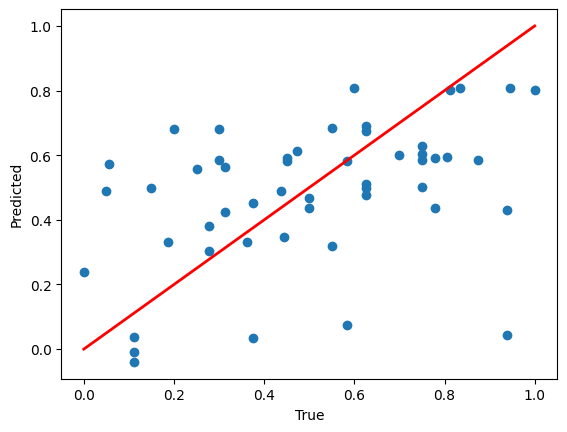

In [83]:
# plot y_pred vs y_true
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
# plot the line y=x
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.show()

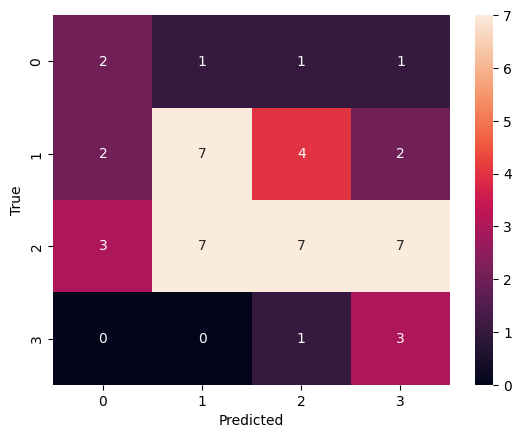

In [82]:
# plot the confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [86]:
# visualize the sequence of input in validation with the highest and lowest prediction
max_pred = np.argmax(y_pred)
min_pred = np.argmin(y_pred)

print('max prediction:')
print(sequences[max_pred])
print(y_pred[max_pred], y_true[max_pred])
print('min prediction:')
print(sequences[min_pred])
print(y_pred[min_pred], y_true[min_pred])




max prediction:
['Q3', 'B', 'T7', 'B', 'T7']
0.8067244291305542 0.8333333134651184
min prediction:
['Q2', 'FA', 'T3', 'FE', 'T6', 'C', 'T1', 'FH', 'T2', 'UH', 'T0', 'UH', 'T1', 'B', 'T7', 'B', 'T8', 'FE', 'T8', 'C', 'T7', 'FA', 'T4', 'FA', 'T2', 'UA', 'T1', 'FA', 'T3', 'UA', 'T1', 'UA', 'T1', 'FA', 'T1', 'FA', 'T1', 'UA', 'T1', 'UE', 'T5', 'C', 'T0', 'UE', 'T5', 'FA', 'T7', 'UE', 'T5', 'UE', 'T1', 'C', 'T0', 'B', 'T6', 'FA', 'T3', 'FE', 'T3', 'FA', 'T3', 'UA', 'T1', 'UA', 'T1', 'FH', 'T2', 'UH', 'T0', 'UH', 'T0', 'FE', 'T6', 'C', 'T1', 'FA', 'T4', 'UA', 'T1', 'FA', 'T1', 'FA', 'T2', 'UA', 'T0', 'UE', 'T3', 'UE', 'T1', 'FA', 'T8', 'UA', 'T0', 'FA', 'T1', 'B', 'T4', 'FA', 'T8', 'UA', 'T0', 'UA', 'T1', 'UA', 'T1', 'UA', 'T0', 'UA', 'T1', 'FA', 'T0', 'UA', 'T0', 'UA', 'T0', 'UA', 'T1', 'UA', 'T0', 'FE', 'T1', 'C', 'T1', 'B', 'T6', 'FA', 'T7', 'UA', 'T1', 'UA', 'T1', 'UA', 'T0', 'UA', 'T1', 'UA', 'T1', 'UA', 'T0', 'UA', 'T1', 'UA', 'T1', 'UA', 'T0', 'FE', 'T5', 'B', 'T3', 'FA', 'T3', 'UA', 

In [95]:
# show the sequence with the most accurate and least accurate prediction
max_pred = np.argmax(np.abs(y_pred-y_true))
min_pred = np.argmin(np.abs(y_pred-y_true))
print(max_pred, min_pred)

print('worst prediction:')
print(sequences[max_pred])
print(y_pred[max_pred], y_true[max_pred])
print('Best prediction:')
print(sequences[min_pred])
print(y_pred[min_pred], y_true[min_pred])


43 35
worst prediction:
['Q1', 'FH', 'T5', 'FA', 'T5', 'C', 'T1', 'FE', 'T5', 'UE', 'T6', 'UE', 'T5', 'UE', 'T6', 'UE', 'T6', 'UE', 'T5', 'UE', 'T5', 'UE', 'T5', 'UE', 'T1', 'UE', 'T1', 'UE', 'T5', 'UE', 'T1', 'UE', 'T2', 'UE', 'T2', 'UE', 'T2', 'UE', 'T2', 'UE', 'T5', 'UE', 'T5', 'UE', 'T0', 'UE', 'T1', 'UE', 'T1', 'UE', 'T1', 'UE', 'T1', 'UE', 'T3', 'UE', 'T6', 'UE', 'T4', 'UE', 'T4', 'UE', 'T4', 'UE', 'T2', 'UE', 'T3', 'FA', 'T6', 'FE', 'T8', 'UE', 'T2', 'UE', 'T2', 'UE', 'T2', 'UE', 'T4', 'C', 'T0', 'FH', 'T1']
0.044865358620882034 0.9375
Best prediction:
['Q3', 'PA', 'T4', 'RF', 'T4', 'RC', 'T0', 'RF', 'T4', 'C', 'T1', 'C', 'T0', 'FE', 'T1', 'C', 'T0', 'PA', 'T5', 'PA', 'T2', 'RF', 'T2', 'FE', 'T2', 'PA', 'T5', 'RF', 'T6', 'C', 'T5', 'C', 'T1', 'PA', 'T3', 'UA', 'T2', 'UA', 'T0', 'PA', 'T5', 'PA', 'T1', 'PA', 'T2', 'PA', 'T6', 'PA', 'T8', 'PA', 'T2', 'PA', 'T3', 'PA', 'T2', 'PA', 'T6', 'UA', 'T3', 'UA', 'T0', 'PA', 'T0', 'PA', 'T1', 'C', 'T1', 'FA', 'T3', 'FA', 'T1', 'FA', 'T2', '

## simpler model

In [47]:
wandb.init(project="DaTu_prediction", entity="marslab", name = "distilbert-base-uncased")

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▆▅▄▄▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▂▁▆▄▂▃▁▃▃▆█▆▄▆▅▃▅▅▇▅▆▆▆▆▆▆▃▅▅▄▆▆▄▅▅▆▅▆▅▅
epoch,50
train_loss,0.01779
validation_loss,0.07142


In [48]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
new_tokens = ['UA','FA','PA','FH', 'UH', 'RH','FE', 'UE','RF', 'RC', 'B', 'C','M', 'S',
    'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'TMAX', 
    'Q1', 'Q2', 'Q3']
tokenizer.add_tokens(new_tokens)

model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size to include new tokens
#

Embedding(30538, 768)

In [ ]:
# optional

model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Increase dropout
    nn.Linear(model.classifier.in_features, 1)
)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30538, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

In [51]:
# Create the dataset and dataloader
dataset = DaTuDataset(sequences,  scores, tokenizer)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=None)

In [52]:
epochs = 50
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4, num_training_steps=total_steps)

/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Epoch 1/50 | Train Loss: 0.096 | Validation Loss: 0.049
Epoch 6/50 | Train Loss: 0.057 | Validation Loss: 0.039
Epoch 11/50 | Train Loss: 0.031 | Validation Loss: 0.058
Epoch 16/50 | Train Loss: 0.029 | Validation Loss: 0.049
Epoch 21/50 | Train Loss: 0.023 | Validation Loss: 0.057
Epoch 26/50 | Train Loss: 0.025 | Validation Loss: 0.052
Epoch 31/50 | Train Loss: 0.021 | Validation Loss: 0.056
Epoch 36/50 | Train Loss: 0.022 | Validation Loss: 0.061
Epoch 41/50 | Train Loss: 0.020 | Validation Loss: 0.052
Epoch 46/50 | Train Loss: 0.020 | Validation Loss: 0.054


[[ 2.  2.  3.  0.]
 [ 4.  5.  4.  1.]
 [ 2. 11.  6.  3.]
 [ 0.  1.  4.  3.]]


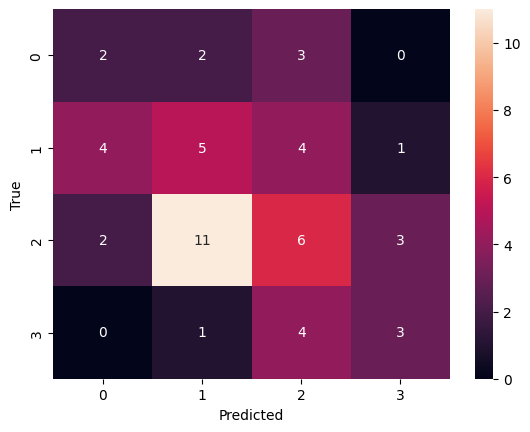

In [54]:
# compute a quality metric for the model
y_pred = []
y_true = []
model.eval()
for batch in val_dataloader:
    batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}  # Move batch to device
    with torch.no_grad():
        outputs = model(**batch)
        y_pred.extend(outputs.logits.squeeze(1).tolist())
        y_true.extend(batch['labels'].tolist())

# calculate the confusion matrix by values 0-0.25, 0.25-`0.5, 0.5-0.75, 0.75-1
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred_bin = np.round(y_pred, 2)
y_true_bin = np.round(y_true, 2)
confusion_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        confusion_matrix[i, j] = np.sum((y_pred_bin >= i*0.25) & (y_pred_bin < (i+1)*0.25) & (y_true_bin >= j*0.25) & (y_true_bin < (j+1)*0.25))
print(confusion_matrix)


sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


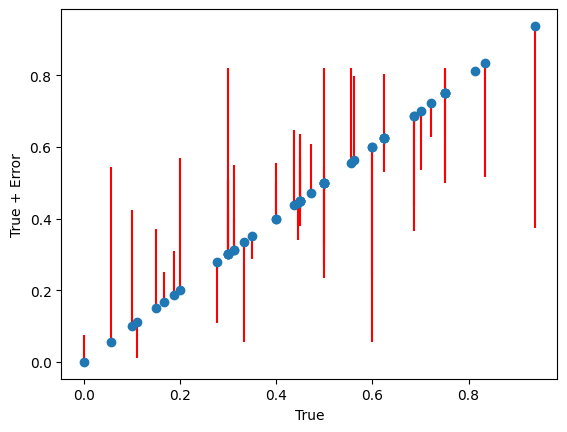

In [67]:
# sort the values of y_true, then change the y_pred accordingly
y_true_sorted = np.sort(y_true)
y_pred_sorted = y_pred[np.argsort(y_true)]

# compute yerr up and down error
yerr = y_pred_sorted - y_true_sorted
yerr_up = [0 if x < 0 else x for x in yerr]
yerr_down = [0 if x > 0 else -x for x in yerr]
yerr_ud = np.array([yerr_down, yerr_up])

# plot errorbar  (y_true - y_pred) for each value of y_true
plt.errorbar(y_true_sorted,y_true_sorted,yerr= yerr_ud, fmt='o',ecolor = "red")
plt.xlabel('True')
plt.ylabel('True + Error')
plt.show()


## Ciriculum learning

In [69]:
wandb.init(project="DaTu_prediction", entity="marslab", name = "distilbert-Ciriculum")

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▅▅▄▅▃▂▂▂▂▂▁▁▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▃▃▁▁█▂▂▄▃▃▂▃▅▄▆▄▃▃▄▃▃▃▄▄▄▄▄▅▃▄▄▃▄▃▄▄▄▃▄
epoch,50
train_loss,0.01795
validation_loss,0.05306


In [70]:
class CurriculumDaTuDatasett(Dataset):
    def __init__(self, sequences, scores, tokenizer, max_length=512):
        self.sequences = sequences
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Compute complexity of each sequence (e.g., length of the sequence)
        self.complexity = [len(seq) for seq in sequences]

        # Sort the dataset by complexity
        self._sort_by_complexity()

    def _sort_by_complexity(self):
        # Sort sequences, problem_ids, grades, and complexity based on complexity
        combined = sorted(zip(self.sequences, self.scores, self.complexity), key=lambda x: x[2])
        self.sequences, self.scores, self.complexity = zip(*combined)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        score = self.scores[idx]

        # Tokenize the sequence
        inputs = self.tokenizer.encode_plus(
            sequence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_length,  # Max length to truncate/pad
            padding='max_length',  # Pad to max_length
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  # Return PyTorch tensors
        )
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': torch.tensor(score, dtype=torch.float)
        }

In [71]:
# Create the dataset and dataloader
dataset = CurriculumDaTuDatasett(sequences,  scores, tokenizer)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=None)

In [72]:
epochs = 50
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4, num_training_steps=total_steps)

/localhome/pagand/projects/mygitsDaTu/AITutor_SeqModeling/myenv/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Epoch 1/50 | Train Loss: 0.037 | Validation Loss: 0.051
Epoch 6/50 | Train Loss: 0.036 | Validation Loss: 0.042
Epoch 11/50 | Train Loss: 0.028 | Validation Loss: 0.029
Epoch 16/50 | Train Loss: 0.029 | Validation Loss: 0.037
Epoch 21/50 | Train Loss: 0.025 | Validation Loss: 0.045
Epoch 26/50 | Train Loss: 0.022 | Validation Loss: 0.040
Epoch 31/50 | Train Loss: 0.020 | Validation Loss: 0.037
Epoch 36/50 | Train Loss: 0.022 | Validation Loss: 0.040
Epoch 41/50 | Train Loss: 0.020 | Validation Loss: 0.038
Epoch 46/50 | Train Loss: 0.019 | Validation Loss: 0.040


[[ 3.  3.  0.  1.]
 [ 1. 14.  6.  1.]
 [ 1.  5.  9.  5.]
 [ 0.  0.  0.  0.]]


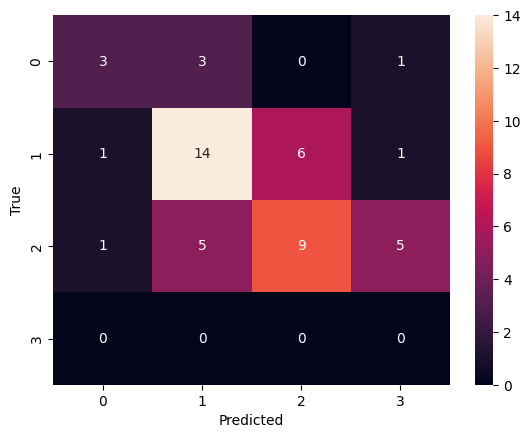

In [74]:
# compute a quality metric for the model
y_pred = []
y_true = []
model.eval()
for batch in val_dataloader:
    batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}  # Move batch to device
    with torch.no_grad():
        outputs = model(**batch)
        y_pred.extend(outputs.logits.squeeze(1).tolist())
        y_true.extend(batch['labels'].tolist())

# calculate the confusion matrix by values 0-0.25, 0.25-`0.5, 0.5-0.75, 0.75-1
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred_bin = np.round(y_pred, 2)
y_true_bin = np.round(y_true, 2)
confusion_matrix = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        confusion_matrix[i, j] = np.sum((y_pred_bin >= i*0.25) & (y_pred_bin < (i+1)*0.25) & (y_true_bin >= j*0.25) & (y_true_bin < (j+1)*0.25))
print(confusion_matrix)


sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

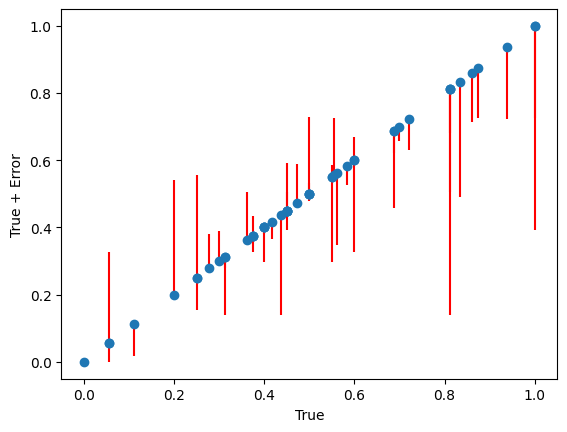

In [75]:
# sort the values of y_true, then change the y_pred accordingly
y_true_sorted = np.sort(y_true)
y_pred_sorted = y_pred[np.argsort(y_true)]

# compute yerr up and down error
yerr = y_pred_sorted - y_true_sorted
yerr_up = [0 if x < 0 else x for x in yerr]
yerr_down = [0 if x > 0 else -x for x in yerr]
yerr_ud = np.array([yerr_down, yerr_up])

# plot errorbar  (y_true - y_pred) for each value of y_true
plt.errorbar(y_true_sorted,y_true_sorted,yerr= yerr_ud, fmt='o',ecolor = "red")
plt.xlabel('True')
plt.ylabel('True + Error')
plt.show()


## LORA

In [45]:
wandb.init(project="DaTu_prediction", entity="marslab", name = "lora-Ciriculum-distilbert")

train_loss,█▄▅▄▄▃▂▃▂▂▁▂▃▂▁▁
validation_loss,▁▁▃▄▃▄█▄▇▄▇▄▅▄▆▅
train_loss,0.02079
validation_loss,0.04859


In [46]:
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

In [47]:
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, 
    inference_mode=False, 
    r=8, 
    lora_alpha=8, 
    lora_dropout=0.1, 
    target_modules="all-linear",
    bias="all"
)

In [48]:
model_peft = get_peft_model(model, peft_config)
model_peft.print_trainable_parameters()

trainable params: 1,324,809 || all params: 68,258,322 || trainable%: 1.9408754290795487


In [49]:
epochs = 16
optimizer = AdamW(model_peft.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/localhome/pagand/projects/DaTu/ML/.venv/lib/python3.8/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Epoch 1/16 | Train Loss: 0.019 | Validation Loss: 0.050
Epoch 2/16 | Train Loss: 0.021 | Validation Loss: 0.048
Epoch 3/16 | Train Loss: 0.019 | Validation Loss: 0.047
Epoch 4/16 | Train Loss: 0.020 | Validation Loss: 0.047
Epoch 5/16 | Train Loss: 0.018 | Validation Loss: 0.049
Epoch 6/16 | Train Loss: 0.021 | Validation Loss: 0.048
Epoch 7/16 | Train Loss: 0.022 | Validation Loss: 0.049
Epoch 8/16 | Train Loss: 0.019 | Validation Loss: 0.048
Epoch 9/16 | Train Loss: 0.020 | Validation Loss: 0.049
Epoch 10/16 | Train Loss: 0.020 | Validation Loss: 0.047
Epoch 11/16 | Train Loss: 0.020 | Validation Loss: 0.048
Epoch 12/16 | Train Loss: 0.019 | Validation Loss: 0.048
Epoch 13/16 | Train Loss: 0.019 | Validation Loss: 0.048
Epoch 14/16 | Train Loss: 0.020 | Validation Loss: 0.048
Epoch 15/16 | Train Loss: 0.019 | Validation Loss: 0.048
Epoch 16/16 | Train Loss: 0.018 | Validation Loss: 0.048


## data augmentation

In [60]:
wandb.init(project="DaTu_prediction", entity="marslab", name = "augment-lora-Ciriculum-distilbert")

train_loss,█▂▃▂▃▂▄▂▃▂▃▂▃▃▁▂
validation_loss,█▄▃▃▂▁▂▂▂▁▁▂▂▁▁▁
train_loss,0.06102
validation_loss,0.06525


In [52]:
import random

def augment_sequence(sequences, max_changes, action_prob , time_prob):
    all_sequences = []
    for sequence in sequences:
        all_sequences.append(sequence)
       

        augmented_sequence = []
        number_of_changes = 0
        i = 0

        while i <len(sequence):

            if number_of_changes>=max_changes:
                augmented_sequence.extend(sequence[i:])
                all_sequences.append(augmented_sequence)
                augmented_sequence = sequence[:i]
            
            token = sequence[i]
            if token.startswith('Q'): # dont change the problem id
                augmented_sequence.append(token)
                i+=1
                continue
            elif token.startswith('T'): # vary time intervals
                # Extract the time value and apply variance
                # 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'TMAX',
                if random.random() < time_prob:
                    number_of_changes += 1
                    time_val = int(token[1:]) if token != 'TMAX' else 8
                    # choose a random time interval with normal distribution mean = time_val, std = time_prob
                    time_val = max(0, min(8, int(np.random.normal(time_val, time_prob))))
                    augmented_sequence.append('T' + str(time_val))
                else:
                    augmented_sequence.append(token)
            else: # 'UA','FA','PA','FH', 'UH', 'RH','FE', 'UE','RF', 'RC', 'B', 'C','M', 'S',
            # Randomly decide to repeat or skip an action
                action = token
                p = random.random()
                number_of_changes += 1
                if p < action_prob:
                    # Repeat action
                    # randomply select a time interval from T0, T1, T2
                    augmented_sequence.extend([action, 'T' + str(random.randint(0, 2)), action])
                elif p < 2 * action_prob:
                    # Skip action
                    i+=2 # skip the time
                    continue
                elif p < 2.5 * action_prob:
                    # Insert a random action
                    action_list = ['UA','FA','PA','FH', 'UH', 'RH','FE', 'UE','RF', 'RC', 'B', 'C','M', 'S']
                    augmented_sequence.extend([random.choice(action_list), 'T' + str(random.randint(0, 2)), action])
                else:
                    augmented_sequence.append(action)
                    number_of_changes -= 1
            i+=1

        all_sequences.append(augmented_sequence)
    return all_sequences

In [53]:
augmented_sequences = augment_sequence(sequences, max_changes=10, action_prob = 0.005, time_prob=0.03)
print(len(augmented_sequences), len(sequences))

7554 254


In [58]:
# Create the dataset and dataloader
dataset = CurriculumDaTuDatasett(augmented_sequences,  scores, tokenizer)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, _ = random_split(dataset, [train_size, val_size])  # keep the validation the same

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=None)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=None)

In [61]:
epochs = 16
optimizer = AdamW(model_peft.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/localhome/pagand/projects/DaTu/ML/.venv/lib/python3.8/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
train_val_loop(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Epoch 1/16 | Train Loss: 0.063 | Validation Loss: 0.041
Epoch 2/16 | Train Loss: 0.065 | Validation Loss: 0.040
Epoch 3/16 | Train Loss: 0.065 | Validation Loss: 0.041
Epoch 4/16 | Train Loss: 0.065 | Validation Loss: 0.042
Epoch 5/16 | Train Loss: 0.063 | Validation Loss: 0.041
Epoch 6/16 | Train Loss: 0.062 | Validation Loss: 0.040
Epoch 7/16 | Train Loss: 0.062 | Validation Loss: 0.042
Epoch 8/16 | Train Loss: 0.067 | Validation Loss: 0.042
Epoch 9/16 | Train Loss: 0.065 | Validation Loss: 0.042
Epoch 10/16 | Train Loss: 0.064 | Validation Loss: 0.041
Epoch 11/16 | Train Loss: 0.065 | Validation Loss: 0.041
Epoch 12/16 | Train Loss: 0.063 | Validation Loss: 0.041
Epoch 13/16 | Train Loss: 0.063 | Validation Loss: 0.042
Epoch 14/16 | Train Loss: 0.065 | Validation Loss: 0.042
Epoch 15/16 | Train Loss: 0.065 | Validation Loss: 0.042
Epoch 16/16 | Train Loss: 0.065 | Validation Loss: 0.042


# make sure the validation is not fixed unlike the train that is augmented